In [519]:
## import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## logistic regression and data handling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## neural network library
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from mlxtend.plotting import plot_confusion_matrix

In [520]:
# load the data set
data = pd.read_csv("diabetes.csv")
# check columns and see typical data set
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [521]:
data.info()
# see data types and find there's no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


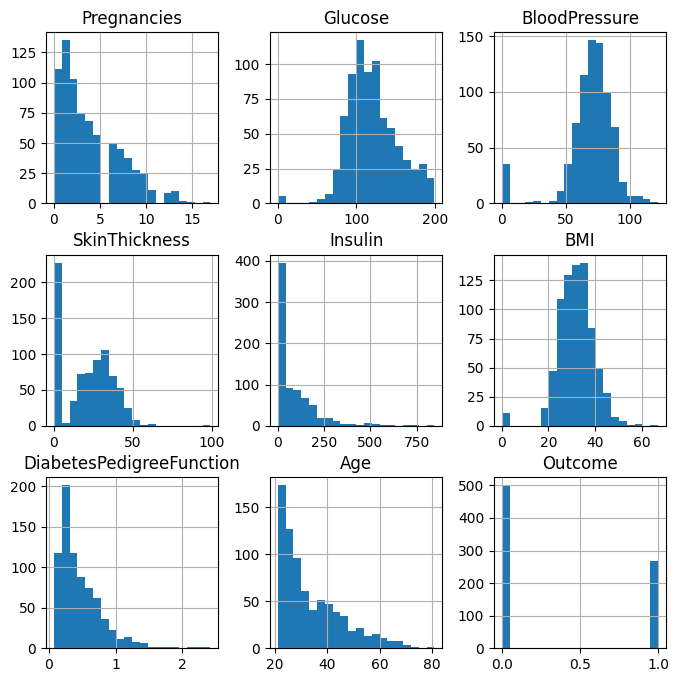

In [522]:
# overall histograms for dataset
data.hist(bins=20, figsize=(8,8))
plt.savefig("diabetes_plots/overall_hist.png")
# shows some weird spikes at zero for many features, suggests null data has been entered as 0

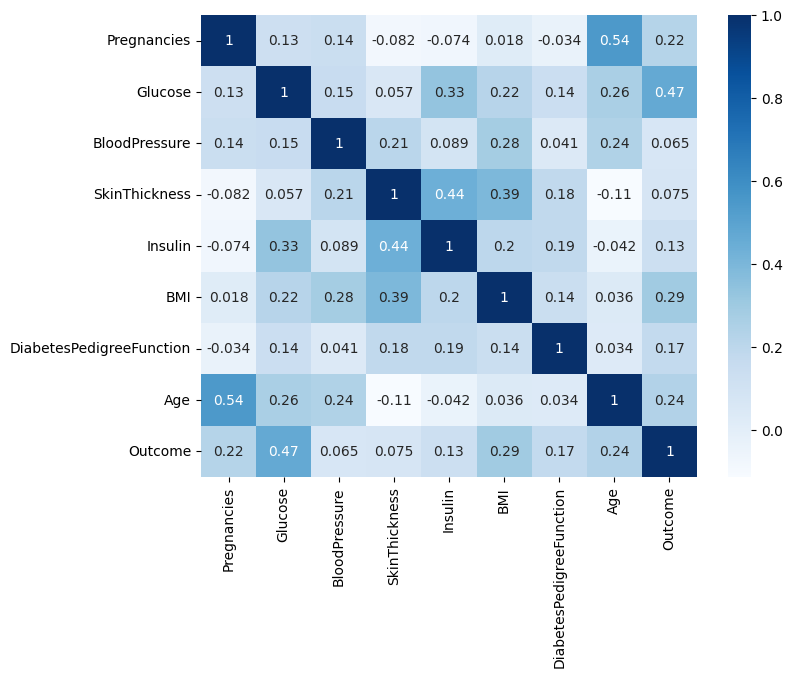

In [523]:
# correlation matrix for diabetes dataset
fig = plt.figure(figsize=(8,6))
sns.heatmap(data.corr(),cmap="Blues",annot=True)
plt.savefig('diabetes_plots/corr_matrix.png', bbox_inches = 'tight')

C:\Users\aferg\AppData\Local\Temp\ipykernel_5936\4161808525.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i,j] = data.median()[j]


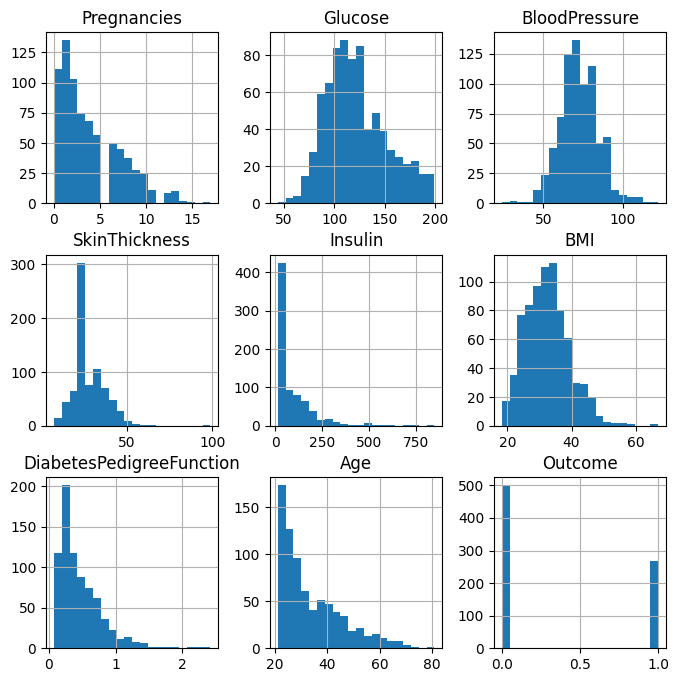

In [524]:
# data cleaning
# setting all null values to the median
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for j in columns:
    for i in range(data.shape[0]):
        if data.loc[i,j] == 0:
            data.loc[i,j] = data.median()[j]

data.hist(bins=20, figsize=(8,8))
plt.savefig("diabetes_plots/overall_hist_no_null.png")

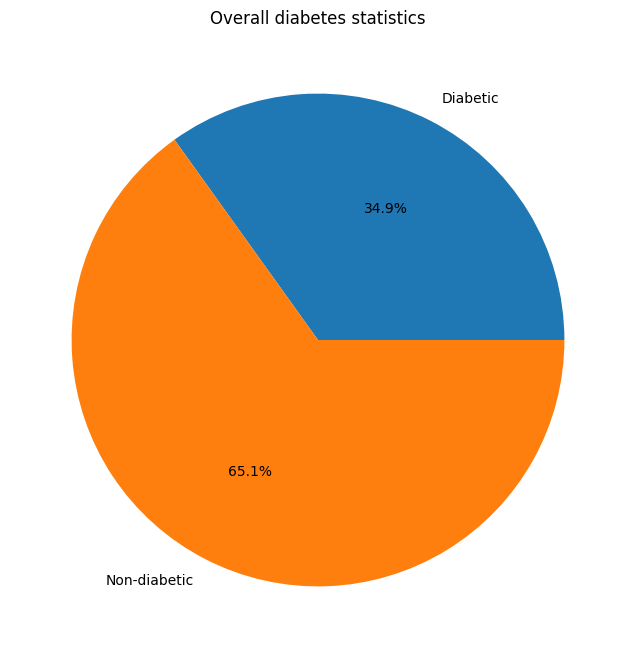

In [525]:
# pie chart showing overall outcome

fig, ax = plt.subplots(figsize=(8,8))
data['Outcome'].sum()
plt.pie([data['Outcome'].sum(), data.shape[0] - data['Outcome'].sum()], labels=['Diabetic', 'Non-diabetic'], autopct='%1.1f%%')
ax.set_title("Overall diabetes statistics")
plt.savefig("diabetes_plots/outcome.png")

Text(0.5, 1.0, 'Age Distribution for Diabetic Population')

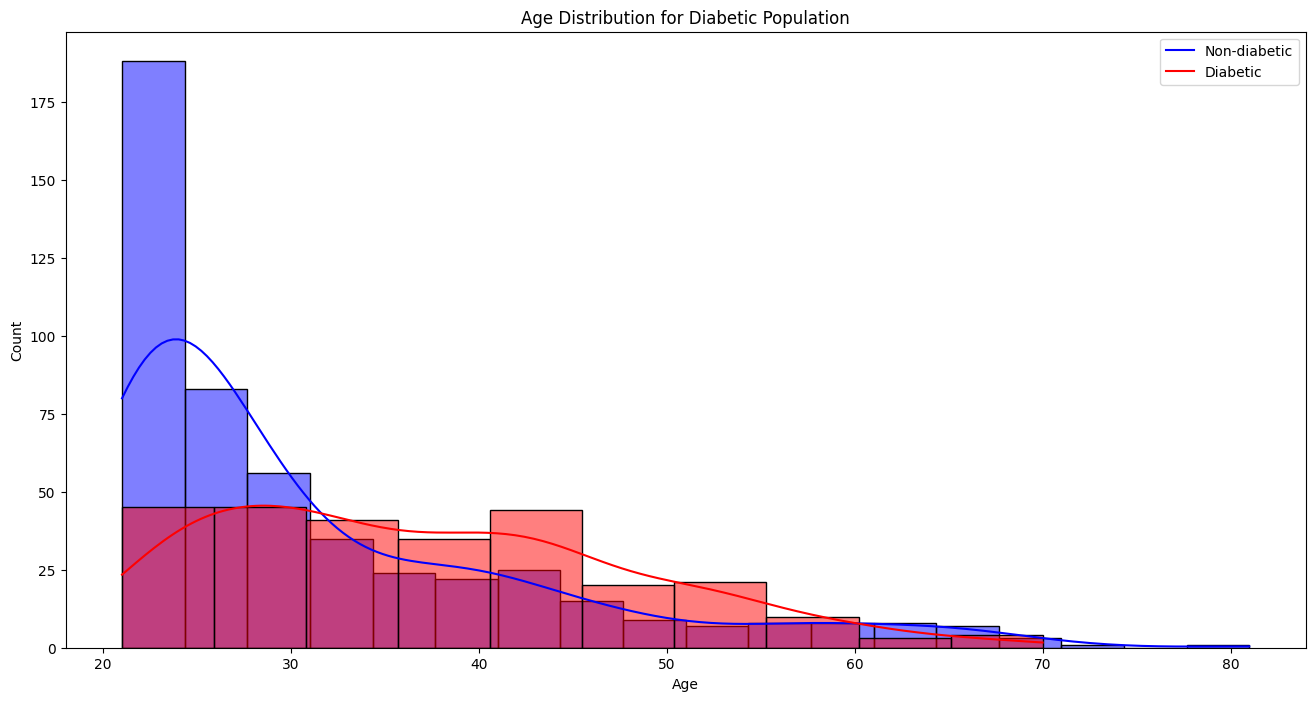

In [526]:
## Visualise the population age distribution between the diabetic and non-diabetic
plt.figure(figsize=(16,8))
ax = sns.histplot(data["Age"][data.Outcome == 0], color="blue", kde=True), sns.histplot(data["Age"][data.Outcome == 1], color="red", kde=True)
plt.legend(['Non-diabetic', 'Diabetic'])
plt.title('Age Distribution for Diabetic Population')

Text(0.5, 1.0, 'BMI Distribution for Diabetic Population')

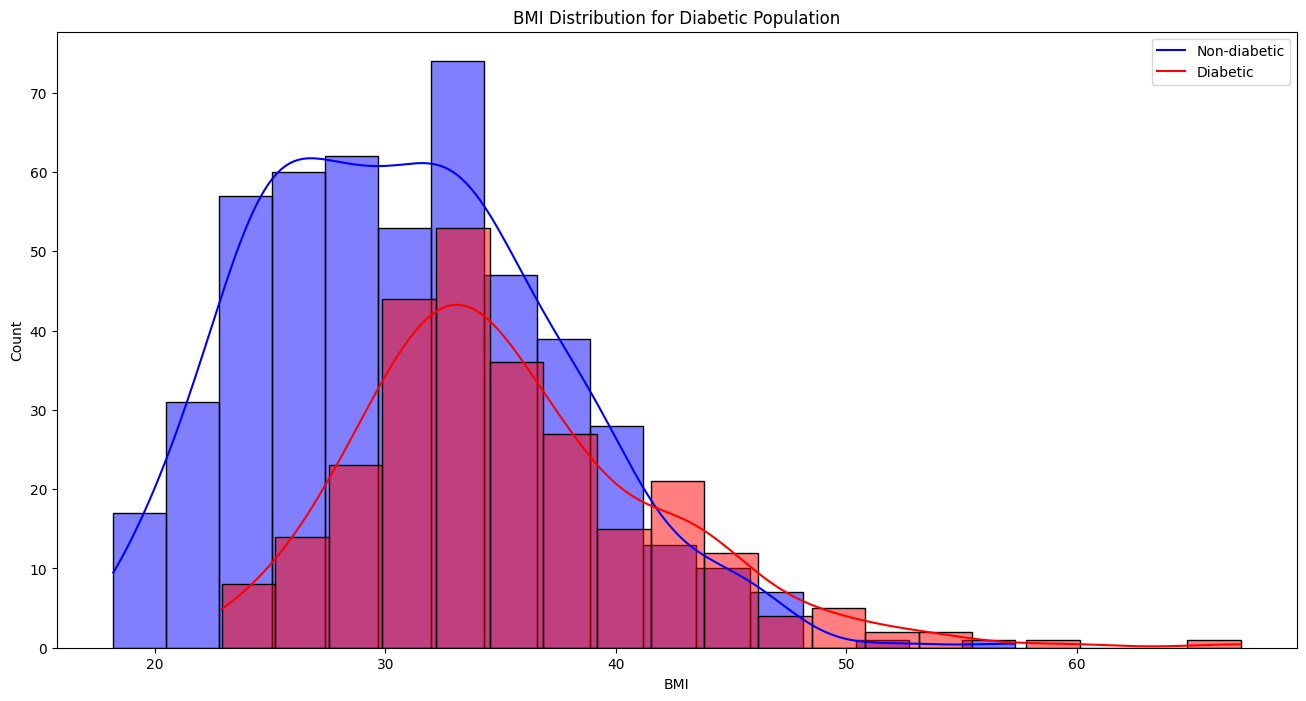

In [527]:
## Visualise the population BMI distribution between the diabetic and non-diabetic
plt.figure(figsize=(16,8))
ax = sns.histplot(data["BMI"][data.Outcome == 0], color="blue", kde=True), sns.histplot(data["BMI"][data.Outcome == 1], color="red", kde=True)
plt.legend(['Non-diabetic', 'Diabetic'])
plt.title('BMI Distribution for Diabetic Population')

Text(0.5, 1.0, 'Diabetes Pedigree Function Distribution for Diabetic Population')

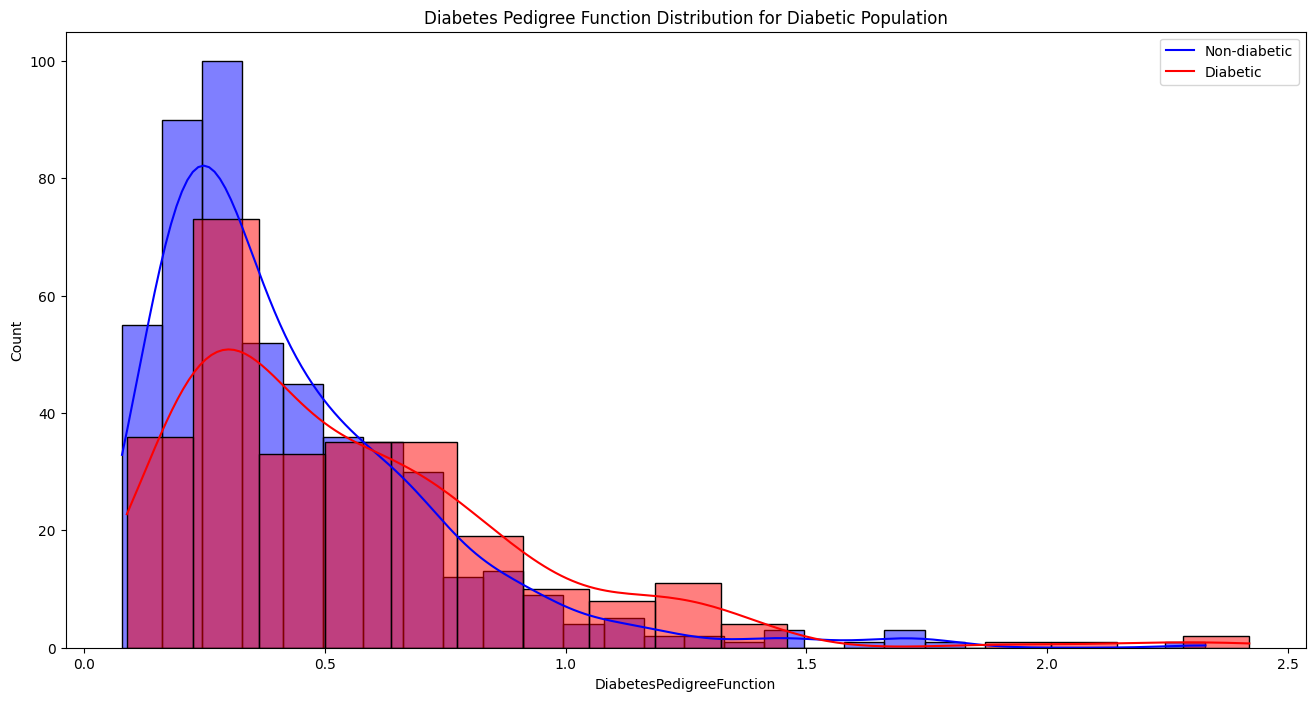

In [528]:
## Visualise the population Diabetes pedigree function distribution between the diabetic and non-diabetic
plt.figure(figsize=(16,8))
ax = sns.histplot(data["DiabetesPedigreeFunction"][data.Outcome == 0], color="blue", kde=True), sns.histplot(data["DiabetesPedigreeFunction"][data.Outcome == 1], color="red", kde=True)
plt.legend(['Non-diabetic', 'Diabetic'])
plt.title('Diabetes Pedigree Function Distribution for Diabetic Population')

Text(0.5, 1.0, 'Glucose Distribution for Diabetic Population')

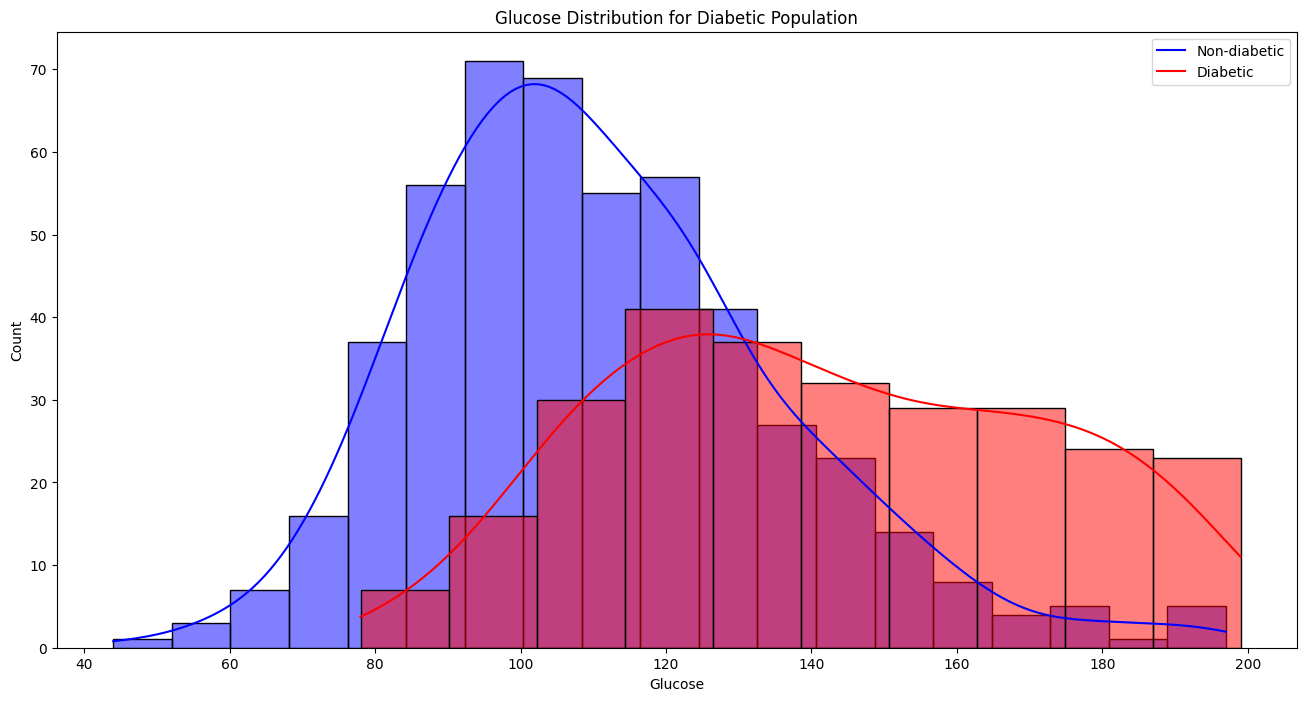

In [529]:
## Visualise the population Glucose distribution between the diabetic and non-diabetic
plt.figure(figsize=(16,8))
ax = sns.histplot(data["Glucose"][data.Outcome == 0], color="blue", kde=True), sns.histplot(data["Glucose"][data.Outcome == 1], color="red", kde=True)
plt.legend(['Non-diabetic', 'Diabetic'])
plt.title('Glucose Distribution for Diabetic Population')

In [530]:
# data standardisation and splitting
data_to_use = data.iloc[:,1:8]
data_to_target = data.iloc[:,8]

# split data 20% for testing 80% for training
x_train, x_test, y_train, y_test = train_test_split(data_to_use, data_to_target, test_size=0.2, random_state=6) 

# normalise data to fit mean 0 variance 1
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# create statistics dataframe to store accuracy and runtime etc.
acc_db = pd.DataFrame(columns=['Accuracy', 'Run Time (s)'])

In [531]:
# Logistic regression model
start = time.time()
log_reg = LogisticRegression()
# train the model
log_reg.fit(x_train, y_train)
# test model on test data
y_pred_log = log_reg.predict(x_test)
# measure runtime of model
run_time = time.time() - start

db = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_log})

acc_db.loc['Logistic regression'] = [metrics.accuracy_score(y_test,y_pred_log), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,0.785714,0.00496


In [532]:
# Gaussian naive bayes model

start = time.time()
gnb = GaussianNB()
# train the model
gnb.fit(x_train,y_train)
# test model on test data
y_pred_gnb = gnb.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction to dataframe
df_gnb = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_gnb})

acc_db.loc['Gaussian naive Bayes'] = [metrics.accuracy_score(y_test, y_pred_gnb), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,0.785714,0.00496
Gaussian naive Bayes,0.759740,0.00248


In [533]:
# find best k for knn model
bestacc = 0
for k in range(30):
    knn_model = KNeighborsClassifier(n_neighbors=k+1)
    knn_model.fit(x_train, y_train)
    y_pred_knn = knn_model.predict(x_test)
    if metrics.accuracy_score(y_test, y_pred_knn) > bestacc:
        bestk = k+1
        bestacc = metrics.accuracy_score(y_test, y_pred_knn)

# kNN model best number of neighbours

start = time.time()
knn_model = KNeighborsClassifier(n_neighbors=bestk)
# train the model
knn_model.fit(x_train, y_train)
# test model on test data
y_pred_knn = knn_model.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction to dataframe
df_knn = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_knn})

acc_db.loc['k Neighbours k='+str(bestk)] = [metrics.accuracy_score(y_test, y_pred_knn), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,0.785714,0.004960
Gaussian naive Bayes,0.759740,0.002480
k Neighbours k=14,0.831169,0.010913


In [534]:
# support vector with variable kernel - options: {‘linear’, 'poly', ‘rbf’, ‘sigmoid’}
start = time.time()
kernel = 'linear'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

start = time.time()
kernel = 'poly'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

start = time.time()
kernel = 'rbf'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

start = time.time()
kernel = 'sigmoid'
svr = svm.SVC(kernel=kernel, degree=4)
# train the model
svr.fit(x_train,y_train)
# test model on test data
y_pred_svr = svr.predict(x_test)
# measure runtime of model
run_time = time.time() - start

# add prediction and actual to database
db_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# add statistics to database
acc_db.loc['Support Vector kernel='+kernel] = [metrics.accuracy_score(y_test, y_pred_svr), run_time]

acc_db


,Accuracy,Run Time (s)
Logistic regression,0.785714,0.004960
Gaussian naive Bayes,0.759740,0.002480
k Neighbours k=14,0.831169,0.010913
Support Vector kernel=linear,0.798701,0.016368
Support Vector kernel=poly,0.714286,0.033728
Support Vector kernel=rbf,0.792208,0.028769
Support Vector kernel=sigmoid,0.733766,0.015375


In [535]:
# decision tree classifier models with variable depth and criterion
start = time.time()
decisionTree_model_gini = DecisionTreeClassifier(random_state=4000)
# train the model
decisionTree_model_gini.fit(x_train,y_train)
# test model on test data
y_pred_gini = decisionTree_model_gini.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Decision tree'] = [metrics.accuracy_score(y_test, y_pred_gini), run_time]

start = time.time()
decisionTree_model_entropy = DecisionTreeClassifier(criterion="entropy", random_state=4000)
# train the model
decisionTree_model_entropy.fit(x_train,y_train)
# test model on test data
y_pred_entropy = decisionTree_model_entropy.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Decision tree entropy'] = [metrics.accuracy_score(y_test, y_pred_entropy), run_time]

start = time.time()
decisionTree_model_depth3 = DecisionTreeClassifier(max_depth=3)
# train the model
decisionTree_model_depth3.fit(x_train,y_train)
# test model on test data
y_pred_depth3 = decisionTree_model_depth3.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Decision tree depth=3'] = [metrics.accuracy_score(y_test, y_pred_depth3), run_time]

acc_db


,Accuracy,Run Time (s)
Logistic regression,0.785714,0.004960
Gaussian naive Bayes,0.759740,0.002480
k Neighbours k=14,0.831169,0.010913
Support Vector kernel=linear,0.798701,0.016368
Support Vector kernel=poly,0.714286,0.033728
Support Vector kernel=rbf,0.792208,0.028769
Support Vector kernel=sigmoid,0.733766,0.015375
Decision tree,0.714286,0.005955
Decision tree entropy,0.733766,0.005952
Decision tree depth=3,0.746753,0.002978


In [536]:
# random forest classifier with variable n
start = time.time()
n = 1000
rfc = RandomForestClassifier(n_estimators=n)
# train the model
rfc.fit(x_train,y_train)
# test model on test data
y_pred_rfc = rfc.predict(x_test)
# measure runtime of model
run_time = time.time() - start

acc_db.loc['Random Forest n='+str(n)] = [metrics.accuracy_score(y_test, y_pred_depth3), run_time]

acc_db

,Accuracy,Run Time (s)
Logistic regression,0.785714,0.004960
Gaussian naive Bayes,0.759740,0.002480
k Neighbours k=14,0.831169,0.010913
Support Vector kernel=linear,0.798701,0.016368
Support Vector kernel=poly,0.714286,0.033728
Support Vector kernel=rbf,0.792208,0.028769
Support Vector kernel=sigmoid,0.733766,0.015375
Decision tree,0.714286,0.005955
Decision tree entropy,0.733766,0.005952
Decision tree depth=3,0.746753,0.002978


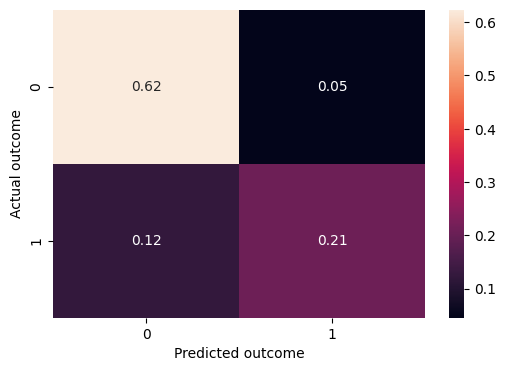

In [537]:
# confusion matrix for best logistic regression model
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat_knn/np.sum(cf_matrix), annot=True, fmt='.2f')
ax.set_ylabel("Actual outcome")
ax.set_xlabel("Predicted outcome")
plt.savefig("diabetes_plots/confusion_matrix_knn.png")

In [538]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       103
           1       0.82      0.63      0.71        51

    accuracy                           0.83       154
   macro avg       0.83      0.78      0.80       154
weighted avg       0.83      0.83      0.82       154



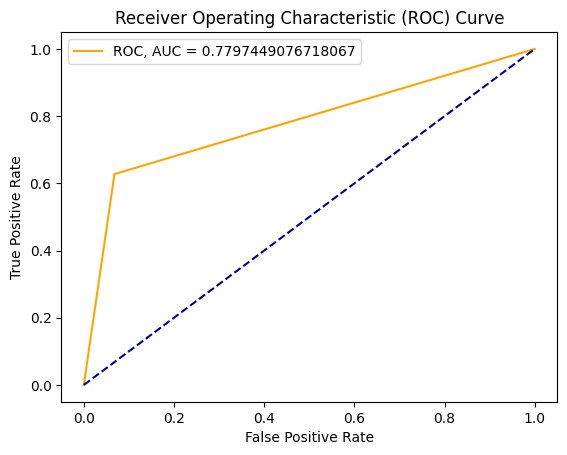

In [539]:
fpr, tpr = roc_curve(y_test, y_pred_knn)[0:2]
auc = roc_auc_score(y_test, y_pred_knn)

plt.plot(fpr, tpr, color='orange', label=f'ROC, AUC = {auc}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [540]:
## neural network
start = time.time()
model = Sequential()

##set up the layers
## input layer
model.add(Dense(units= 100, kernel_initializer= 'uniform', activation = 'leaky_relu', input_dim = 7)) 
## hidden layer 1 
model.add(Dense(units= 30, kernel_initializer= 'uniform', activation = 'leaky_relu')) 
##regularization 1
#model.add(Dropout(0.4)) # setting 40% of the data to zero to avoid overfitting
## hidden layer 2
#model.add(Dense(units= 20, kernel_initializer= 'uniform', activation = 'leaky_relu')) 
## regularization 2
model.add(Dropout(0.2)) # another regularisation to avoid overfitting
## output layer
model.add(Dense(units= 1, kernel_initializer= 'uniform', activation = 'sigmoid')) 

## compiling the ANN
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])

## train the model with early stopping after enough consecutive epochs without improvement in loss
callback = EarlyStopping(monitor='loss', patience=8)
history = model.fit(x_train, y_train, batch_size = 25, epochs = 100, validation_split=0.25, callbacks=[callback])

## test the model
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
run_time = time.time() - start

print(f"Total run time is: {run_time}")
history_df = pd.DataFrame(history.history)

Epoch 1/100


c:\Users\aferg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5793 - loss: 0.6913 - val_accuracy: 0.7078 - val_loss: 0.6802
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7414 - loss: 0.6713 - val_accuracy: 0.7208 - val_loss: 0.6290
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7533 - loss: 0.5991 - val_accuracy: 0.7208 - val_loss: 0.5458
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7243 - loss: 0.5286 - val_accuracy: 0.7532 - val_loss: 0.5245
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7265 - loss: 0.5058 - val_accuracy: 0.7727 - val_loss: 0.5139
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7670 - loss: 0.4640 - val_accuracy: 0.7597 - val_loss: 0.5054
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7613 - loss: 0.4796 - val_accuracy: 0.7727 - val_loss: 0.4961
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7513 - loss: 0.4932 - val_accuracy: 0.7727 - val_loss: 0.

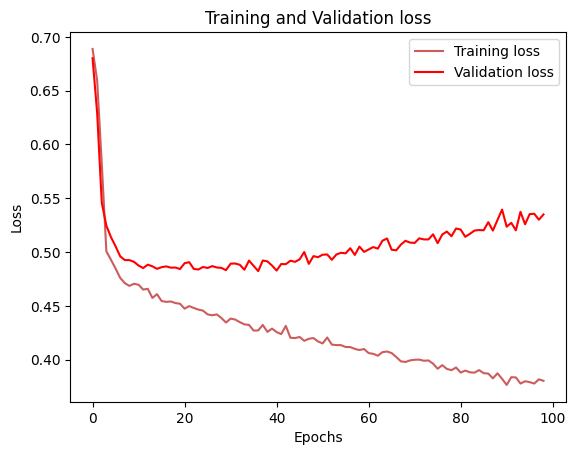

In [541]:
# plot of training and validation loss
plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.savefig("diabetes_plots/loss_chart.png")

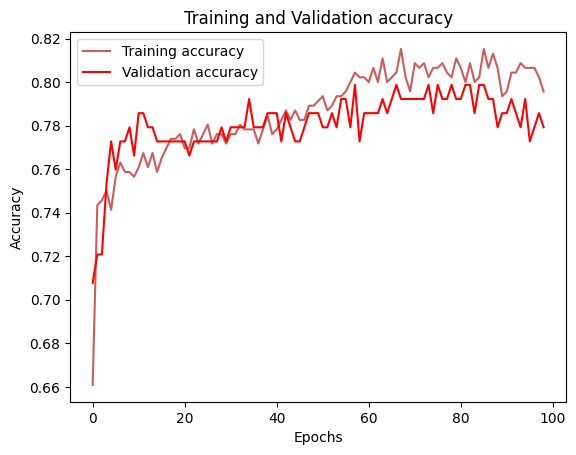

In [542]:
# Training and validation accuracy plot
plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("diabetes_plots/accuracy_chart.png")

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       103
           1       0.74      0.69      0.71        51

    accuracy                           0.82       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.82      0.82      0.82       154



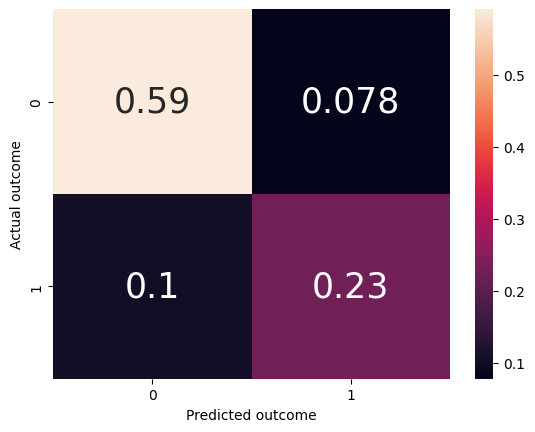

In [543]:
# confusion matrix for neural network
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':25})
plt.ylabel("Actual outcome")
plt.xlabel("Predicted outcome")
plt.savefig("diabetes_plots/confusion_matrix_ann.png")

print(classification_report(y_test, y_pred))